In [333]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
import osmnx as ox
import matplotlib.pyplot as plt
import utils
import numpy as np
from collections import Counter
import seaborn as sns
plt.style.use('ggplot')

In [14]:
def getTotalCars(row:pd.DataFrame)->float:
     
    """
    Calculates the total number of Passenger Car Equivalents (PCE) for various types of vehicles on the road.

    This function uses Passenger Car Equivalent (PCE) values to convert diverse vehicle types 
    (e.g., bicycles, motorbikes, buses, and trucks) into an equivalent measure based on the 
    impact of a single passenger car. This allows for standardized comparison of mixed-traffic flow.

    Parameters:
    ----------
    row : pd.DataFrame
        A DataFrame row containing vehicle count data with specific columns for each vehicle type 
        (e.g., `pedal_cycles`, `two_wheeled_motor_vehicles`, `cars_and_taxis`, etc.).

    Returns:
    -------
    float
        The total Passenger Car Equivalent (PCE) count for the input vehicles, providing a measure 
        of traffic flow impact in terms of passenger car units.

    Notes:
    ------
    PCE factors used for different vehicles:
    - pedal_cycles: 0.2
    - two_wheeled_motor_vehicles: 0.6
    - cars_and_taxis: 1.0
    - buses_and_coaches: 2.5
    - lgvs (Light Goods Vehicles): 1.2
    - hgvs with various axles: ranging from 1.8 to 4.2

    The specific values may vary based on region or local guidelines in traffic engineering.
    """

    total_cars=(row['pedal_cycles'] * utils.PEDAL_CYCLES
                +row['two_wheeled_motor_vehicles'] * utils.TWO_WHEELED_MOTOR_VEHICLES
                +row['cars_and_taxis'] * utils.CARS_AND_TAXIS
                +row['buses_and_coaches'] * utils.BUSES_AND_COACHES
                +row['lgvs'] * utils.LGVS
                +row['hgvs_2_rigid_axle'] * utils.HGVS_2_RIGID_AXLE
                +row['hgvs_3_rigid_axle'] * utils.HGVS_3_RIGID_AXLE
                +row['hgvs_4_or_more_rigid_axle'] * utils.HGVS_4_OR_MORE_RIGID_AXLE
                +row['hgvs_3_or_4_articulated_axle'] * utils.HGVS_3_OR_4_ARTICULATED_AXLE
                +row['hgvs_5_articulated_axle'] * utils.HGVS_5_ARTICULATED_AXLE
                +row['hgvs_6_articulated_axle'] * utils.HGVS_6_ARTICULATED_AXLE)
    return total_cars

In [392]:
raw_df=pd.read_csv('data/raw_count.csv')[['count_point_id','direction_of_travel', 'year','hour','latitude', 'longitude', 'link_length_km',
       'link_length_miles', 'pedal_cycles', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle',
       'hgvs_3_rigid_axle', 'hgvs_4_or_more_rigid_axle',
       'hgvs_3_or_4_articulated_axle', 'hgvs_5_articulated_axle',
       'hgvs_6_articulated_axle', 'all_hgvs']]

raw_df['total_cars']=raw_df.apply(getTotalCars,axis=1)
raw_df

,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars
0,6109,E,2002,7,51.461221,-0.153137,0.6,0.37,34,74,...,19,114,20,4,1,1,2,0,28,711.9
1,6109,E,2002,8,51.461221,-0.153137,0.6,0.37,54,100,...,14,75,29,2,1,0,1,0,33,696.1
2,6109,E,2002,9,51.461221,-0.153137,0.6,0.37,20,46,...,31,105,42,3,5,1,4,0,55,694.4
3,6109,E,2002,10,51.461221,-0.153137,0.6,0.37,9,26,...,19,112,47,8,0,0,2,6,63,697.9
4,6109,E,2002,11,51.461221,-0.153137,0.6,0.37,14,28,...,14,146,56,4,0,0,4,0,64,794.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13219,998097,S,2009,14,51.450833,-0.202202,NaN,NaN,0,1,...,0,13,0,0,0,0,0,0,0,49.2
13220,998097,S,2009,15,51.450833,-0.202202,NaN,NaN,1,0,...,0,11,1,0,0,0,0,0,1,83.2
13221,998097,S,2009,16,51.450833,-0.202202,NaN,NaN,0,3,...,0,10,1,0,0,0,0,0,1,97.6
13222,998097,S,2009,17,51.450833,-0.202202,NaN,NaN,5,1,...,0,12,1,0,0,0,0,0,1,77.8


In [393]:
annaul_daily_df=pd.read_csv('data/aadf_direction.csv')#[['count_point_id','year','road_name','road_type','all_motor_vehicles']]
annaul_daily_df=annaul_daily_df[annaul_daily_df['count_point_id'].isin(raw_df['count_point_id'])]
cur_col=annaul_daily_df.columns
repl_col=[c.lower() for c in cur_col]
my_dict = dict(zip(cur_col, repl_col))
annaul_daily_df.rename(columns=my_dict, inplace=True)

annaul_daily_df['total_cars_aadf']= annaul_daily_df.apply(getTotalCars,axis=1)
annaul_daily_df=annaul_daily_df[['count_point_id','direction_of_travel','year','total_cars_aadf']]
annaul_daily_df

C:\Users\fa71f\AppData\Local\Temp\ipykernel_106052\2729380997.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  annaul_daily_df=pd.read_csv('data/aadf_direction.csv')#[['count_point_id','year','road_name','road_type','all_motor_vehicles']]


,count_point_id,direction_of_travel,year,total_cars_aadf
18343,6109,E,2000,13638.2
18344,6109,W,2000,15465.8
18345,6109,E,2001,13542.4
18346,6109,W,2001,15334.7
18347,6109,E,2002,12815.1
...,...,...,...,...
1049914,998097,S,2007,662.2
1049915,998097,N,2008,922.6
1049916,998097,S,2008,592.6
1049917,998097,N,2009,1206.7


In [394]:
tdf=pd.DataFrame(annaul_daily_df.groupby(['count_point_id'])['year'].unique()).reset_index() # Groups by 'count_point_id' and lists unique years for each

# Calculating and adding columns to summarize year information for each count point:
tdf['total_years'] = tdf['year'].apply(len) # Counts the total number of unique years with data for each count point
tdf['min_year'] = tdf['year'].apply(min) # Finds the earliest (oldest) year with data availability
tdf['max_year'] = tdf['year'].apply(max) # Finds the latest (most recent) year with data availability
#tdf=tdf.merge(annaul_daily_df[['count_point_id','road_name','road_type','all_motor_vehicles']],on='count_point_id', how='left')

tdf

,count_point_id,year,total_years,min_year,max_year
0,6109,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
1,6111,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
2,6757,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
3,6774,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
4,7571,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",24,2000,2023
...,...,...,...,...,...
106,953192,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
107,990355,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
108,998065,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009
109,998071,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...",10,2000,2009


In [398]:
current_sensors=tdf[tdf['max_year']>=2013]['count_point_id'].values
raw_df=raw_df[raw_df['count_point_id'].isin(current_sensors)]

In [401]:
years = range(2013, 2024)
hours = range(7, 19)  # 7 am to 6 pm

# Get unique combinations of count_point_id and direction_of_travel
unique_points = raw_df[['count_point_id', 'direction_of_travel']].drop_duplicates()


# Create a new DataFrame to cover all possible combinations
complete_data = pd.MultiIndex.from_product(
    [unique_points['count_point_id'], unique_points['direction_of_travel'], years, hours],
    names=['count_point_id', 'direction_of_travel', 'year', 'hour']
).to_frame(index=False)


complete_data.drop_duplicates(subset=['count_point_id','direction_of_travel','year','hour'],inplace=True)
complete_data

,count_point_id,direction_of_travel,year,hour
0,6109,E,2013,7
1,6109,E,2013,8
2,6109,E,2013,9
3,6109,E,2013,10
4,6109,E,2013,11
...,...,...,...,...
5877031,951769,S,2023,14
5877032,951769,S,2023,15
5877033,951769,S,2023,16
5877034,951769,S,2023,17


In [402]:
# Merge this complete set with the original data
merged_df = pd.merge(complete_data, raw_df, on=['count_point_id', 'direction_of_travel', 'year', 'hour'], how='left')

merged_df[merged_df['year']==2020]

,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars
84,6109,E,2020,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,6109,E,2020,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,6109,E,2020,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,6109,E,2020,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,6109,E,2020,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45895,951769,S,2020,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45896,951769,S,2020,15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45897,951769,S,2020,16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45898,951769,S,2020,17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [404]:
merged_df=merged_df.merge(annaul_daily_df,on=['count_point_id','year','direction_of_travel'],how='left')
merged_df[(merged_df['year']==2020)&(merged_df['count_point_id']==6109)]

,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars,total_cars_aadf
84,6109,E,2020,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8318.5
85,6109,E,2020,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8318.5
86,6109,E,2020,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8318.5
87,6109,E,2020,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8318.5
88,6109,E,2020,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8318.5
89,6109,E,2020,12,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8318.5
90,6109,E,2020,13,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8318.5
91,6109,E,2020,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8318.5
92,6109,E,2020,15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8318.5
93,6109,E,2020,16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8318.5


In [405]:
merged_df.to_csv('data/refined_raw_count.csv')

In [406]:
merged_df=pd.read_csv('data/refined_raw_count.csv',index_col=0)
merged_df

,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars,total_cars_aadf
0,6109,E,2013,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3
1,6109,E,2013,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3
2,6109,E,2013,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3
3,6109,E,2013,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3
4,6109,E,2013,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45931,951769,S,2023,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45932,951769,S,2023,15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45933,951769,S,2023,16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45934,951769,S,2023,17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [407]:
avg_daily_cars = (
    merged_df.groupby(['count_point_id', 'year','direction_of_travel'])['total_cars']
    .sum()
    .reset_index(name='avg_daily_cars_act')
)

avg_daily_cars

,count_point_id,year,direction_of_travel,avg_daily_cars_act
0,6109,2013,E,0.0
1,6109,2013,N,0.0
2,6109,2013,S,0.0
3,6109,2013,W,0.0
4,6109,2014,E,0.0
...,...,...,...,...
3823,951769,2022,W,0.0
3824,951769,2023,E,0.0
3825,951769,2023,N,0.0
3826,951769,2023,S,0.0


In [408]:
merged_df = merged_df.merge(avg_daily_cars, on=['count_point_id','direction_of_travel', 'year'], how='left')

merged_df

,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars,total_cars_aadf,avg_daily_cars_act
0,6109,E,2013,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0
1,6109,E,2013,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0
2,6109,E,2013,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0
3,6109,E,2013,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0
4,6109,E,2013,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13864.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45931,951769,S,2023,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
45932,951769,S,2023,15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
45933,951769,S,2023,16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
45934,951769,S,2023,17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [409]:
merged_df['hourly_percentage'] = (merged_df['total_cars'] / merged_df['avg_daily_cars_act'])

merged_df[merged_df['year']==2019]

,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars,total_cars_aadf,avg_daily_cars_act,hourly_percentage
72,6109,E,2019,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN
73,6109,E,2019,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN
74,6109,E,2019,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN
75,6109,E,2019,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN
76,6109,E,2019,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45883,951769,S,2019,14,51.450655,-0.241543,NaN,NaN,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,33.6,315.4,262.6,0.127951
45884,951769,S,2019,15,51.450655,-0.241543,NaN,NaN,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23.6,315.4,262.6,0.089871
45885,951769,S,2019,16,51.450655,-0.241543,NaN,NaN,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,19.8,315.4,262.6,0.075400
45886,951769,S,2019,17,51.450655,-0.241543,NaN,NaN,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.4,315.4,262.6,0.092917


In [410]:
hourly_percentage = (
    merged_df.dropna(subset=['hourly_percentage'])
    .groupby(['count_point_id','direction_of_travel', 'hour'])['hourly_percentage']
    .mean()
    .reset_index()
)
hourly_percentage.groupby('direction_of_travel').sum()


,count_point_id,hour,hourly_percentage
direction_of_travel,,,
E,126385392,6450,43.0
N,120988680,5850,39.0
S,121551780,6150,41.0
W,125686596,6300,42.0


In [411]:
# Step 5: Merge these hourly percentages with the main dataset
merged_df = merged_df.merge(hourly_percentage, on=['count_point_id','direction_of_travel', 'hour'], suffixes=('', '_mean'), how='left')

merged_df[merged_df['year']==2019]

,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars,total_cars_aadf,avg_daily_cars_act,hourly_percentage,hourly_percentage_mean
72,6109,E,2019,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN,0.075276
73,6109,E,2019,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN,0.086319
74,6109,E,2019,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN,0.074999
75,6109,E,2019,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN,0.084058
76,6109,E,2019,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10441.3,0.0,NaN,0.081313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45883,951769,S,2019,14,51.450655,-0.241543,NaN,NaN,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,33.6,315.4,262.6,0.127951,0.099895
45884,951769,S,2019,15,51.450655,-0.241543,NaN,NaN,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.6,315.4,262.6,0.089871,0.085524
45885,951769,S,2019,16,51.450655,-0.241543,NaN,NaN,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,19.8,315.4,262.6,0.075400,0.079475
45886,951769,S,2019,17,51.450655,-0.241543,NaN,NaN,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,24.4,315.4,262.6,0.092917,0.087450


In [412]:
# Step 6: Impute missing hourly values based on total_cars_addf and hourly percentage
merged_df['imputed_cars'] = merged_df.apply(
    lambda x: x['hourly_percentage_mean'] * x['total_cars_aadf'] if pd.isna(x['total_cars']) else x['total_cars'],
    axis=1
)
merged_df


,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars,total_cars_aadf,avg_daily_cars_act,hourly_percentage,hourly_percentage_mean,imputed_cars
0,6109,E,2013,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.075276,1043.648893
1,6109,E,2013,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.086319,1196.749094
2,6109,E,2013,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.074999,1039.814177
3,6109,E,2013,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.084058,1165.404862
4,6109,E,2013,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.081313,1127.347028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45931,951769,S,2023,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.099895,NaN
45932,951769,S,2023,15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.085524,NaN
45933,951769,S,2023,16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.079475,NaN
45934,951769,S,2023,17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.087450,NaN


In [413]:
merged_df.to_csv('data/refined_raw_count_data.csv',index=False)

In [424]:
merged_df=pd.read_csv('data/refined_raw_count_data.csv')
merged_df

,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars,total_cars_aadf,avg_daily_cars_act,hourly_percentage,hourly_percentage_mean,imputed_cars
0,6109,E,2013,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.075276,1043.648893
1,6109,E,2013,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.086319,1196.749094
2,6109,E,2013,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.074999,1039.814177
3,6109,E,2013,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.084058,1165.404862
4,6109,E,2013,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.081313,1127.347028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45931,951769,S,2023,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.099895,NaN
45932,951769,S,2023,15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.085524,NaN
45933,951769,S,2023,16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.079475,NaN
45934,951769,S,2023,17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.087450,NaN


In [425]:
merged_df[(merged_df['count_point_id']==6109)&(merged_df['imputed_cars'].isna())]

,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars,total_cars_aadf,avg_daily_cars_act,hourly_percentage,hourly_percentage_mean,imputed_cars
264,6109,N,2013,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
265,6109,N,2013,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
266,6109,N,2013,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
267,6109,N,2013,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
268,6109,N,2013,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,6109,S,2023,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
524,6109,S,2023,15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
525,6109,S,2023,16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
526,6109,S,2023,17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [426]:

merged_df['imputed_cars'] = merged_df.groupby(['count_point_id','hour'])['imputed_cars']\
                        .transform(lambda x: x.fillna(x.mean()))

merged_df


,count_point_id,direction_of_travel,year,hour,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,...,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,total_cars,total_cars_aadf,avg_daily_cars_act,hourly_percentage,hourly_percentage_mean,imputed_cars
0,6109,E,2013,7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.075276,1043.648893
1,6109,E,2013,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.086319,1196.749094
2,6109,E,2013,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.074999,1039.814177
3,6109,E,2013,10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.084058,1165.404862
4,6109,E,2013,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13864.3,0.0,NaN,0.081313,1127.347028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45931,951769,S,2023,14,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.099895,35.385714
45932,951769,S,2023,15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.085524,43.785714
45933,951769,S,2023,16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.079475,47.150000
45934,951769,S,2023,17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.087450,46.085714


In [427]:
len(merged_df['count_point_id'].unique())

87

In [431]:
merged_df.dropna(subset=['imputed_cars'],inplace=True)
len(merged_df['count_point_id'].unique())

84

In [433]:
tdf=pd.DataFrame(merged_df[~merged_df['imputed_cars'].isna()].groupby(['count_point_id'])['year'].unique()).reset_index() # Groups by 'count_point_id' and lists unique years for each

# Calculating and adding columns to summarize year information for each count point:
tdf['total_years'] = tdf['year'].apply(len) # Counts the total number of unique years with data for each count point
tdf['min_year'] = tdf['year'].apply(min) # Finds the earliest (oldest) year with data availability
tdf['max_year'] = tdf['year'].apply(max) # Finds the latest (most recent) year with data availability

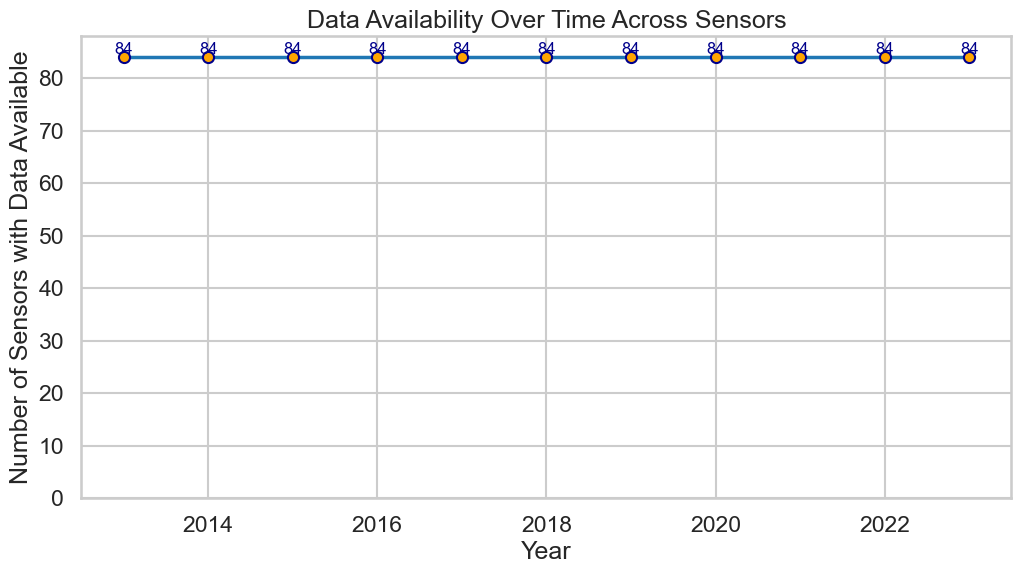

In [434]:
# Flattening the 'year' column to count the occurrence of each year across all sensors
years = [year for sublist in tdf['year'] for year in sublist]
year_counts = Counter(years)

# Creating lists for plotting
years_sorted = sorted(year_counts.keys())
sensor_counts = [year_counts[year] for year in years_sorted]


plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", context="talk")
plt.plot(years_sorted, sensor_counts, marker='o', linestyle='-', color='#1f77b4', linewidth=2.5, markersize=8, markerfacecolor='orange', markeredgewidth=1.5, markeredgecolor='darkblue')

plt.title("Data Availability Over Time Across Sensors")
plt.xlabel("Year")
plt.ylabel("Number of Sensors with Data Available")
for year, count in zip(years_sorted, sensor_counts):
    if count > 1:
        plt.text(year, count + 0.1, f"{count}", ha='center', va='bottom', color='darkblue', fontsize=12)

plt.grid(visible=True)
plt.ylim(0, max(sensor_counts) + 4)

# Showing the plot
plt.show()

C:\Users\fa71f\AppData\Local\Temp\ipykernel_106052\3727670949.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['total_cars_moving_avg'] = df_filtered['total_cars'].rolling(window=window_size, min_periods=1).mean()
C:\Users\fa71f\AppData\Local\Temp\ipykernel_106052\3727670949.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['total_cars_moving_avg'] = df_filtered['total_cars_moving_avg'].interpolate()
C:\Users\fa71f\AppData\Local\Temp\ipykernel_106052\3727670949.py:7: SettingWith

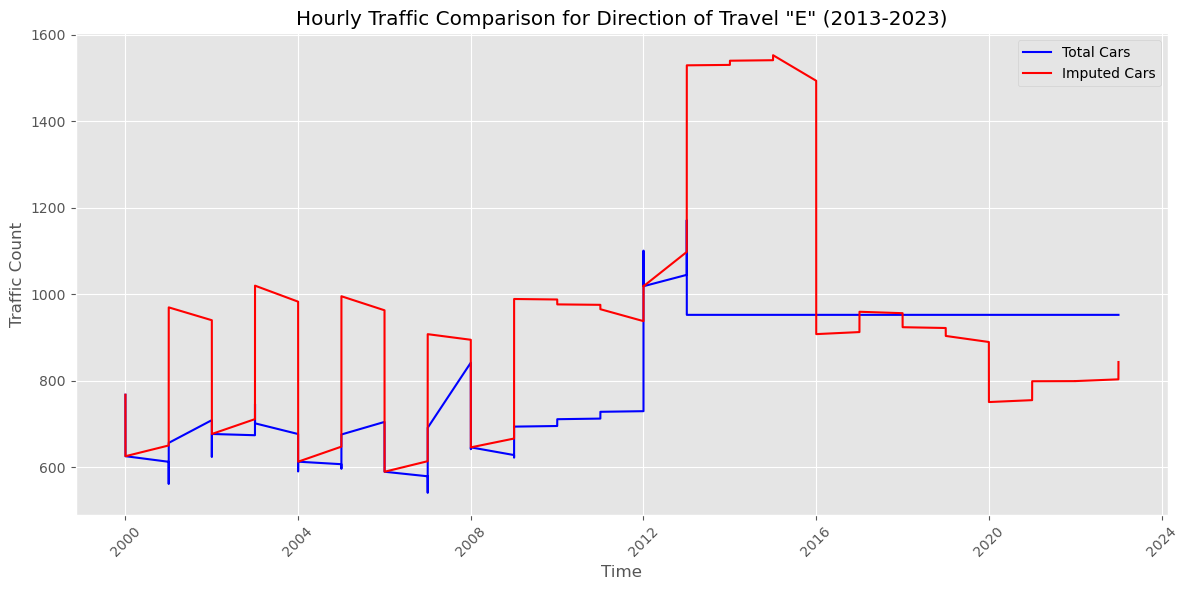

In [280]:
df_filtered = merged_df[(merged_df['direction_of_travel'] == 'N')]
window_size = 12  # Adjust the window as needed

# Moving averages for 'total_cars' and 'imputed_cars' columns
df_filtered['total_cars_moving_avg'] = df_filtered['total_cars'].rolling(window=window_size, min_periods=1).mean()
df_filtered['total_cars_moving_avg'] = df_filtered['total_cars_moving_avg'].interpolate()
df_filtered['imputed_cars_moving_avg'] = df_filtered['imputed_cars'].rolling(window=window_size, min_periods=1).mean()

# Create a time index for plotting by combining year and hour
df_filtered['time'] = pd.to_datetime(df_filtered['year'].astype(str) + '-' + df_filtered['hour'].astype(str), format='%Y-%H')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['time'], df_filtered['total_cars_moving_avg'], label='Total Cars', color='blue')
plt.plot(df_filtered['time'], df_filtered['imputed_cars_moving_avg'], label='Imputed Cars', color='red')
plt.xlabel('Time')
plt.ylabel('Traffic Count')
plt.title('Hourly Traffic Comparison for Direction of Travel "E" (2013-2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [271]:
df_filtered[['time','total_cars','imputed_cars']]

,time,total_cars,imputed_cars
0,2000-01-01 07:00:00,767.6,767.600000
1,2000-01-01 08:00:00,638.8,638.800000
2,2000-01-01 09:00:00,704.8,704.800000
3,2000-01-01 10:00:00,726.3,726.300000
4,2000-01-01 11:00:00,685.3,685.300000
...,...,...,...
283,2023-01-01 14:00:00,NaN,770.096866
284,2023-01-01 15:00:00,NaN,820.553036
285,2023-01-01 16:00:00,NaN,879.495041
286,2023-01-01 17:00:00,NaN,856.271860
